In [2]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import resnet

from eva import KFAC as Eva
from torch_lr_finder import LRFinder
from fastai.vision.all import Learner
from torch.optim.lr_scheduler import CyclicLR

import wandb

In [3]:
arch='resnet110'
workers = 4
epochs = 50
start_epoch = 0
batch_size = 128
lr=0.1
momentum = 0.9
weight_decay = 1e-4
print_freq = 50
resume = False
evaluate = False
save_dir = 'save_resnet110'
save_every = 10
eva = True
lrfinder = True
clr = True

In [7]:

def train(train_loader, model, criterion, optimizer, epoch, preconditioner=None):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda()
        input_var = input.cuda()
        target_var = target

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()

        # eva preconditione
        preconditioner.step()

        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
            
    return top1.avg


def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))

    return top1.avg

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


In [8]:
best_prec1 = 0

wandb.init(project='evaipynb',name='resnet110'+'eva'+'withlrfinder'+"with CLR")

# Check the save_dir exists or not
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model = torch.nn.DataParallel(resnet.__dict__[arch]())
model.cuda()

# optionally resume from a checkpoint
if resume:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
                .format(evaluate, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

cudnn.benchmark = True

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=batch_size, shuffle=True,
    num_workers=workers, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False,
    num_workers=workers, pin_memory=True)

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda()

Files already downloaded and verified


In [41]:
optimizer = torch.optim.SGD(model.parameters(), lr,
                            momentum=momentum,
                            weight_decay=weight_decay)

# preconditioner = Eva(model,)
preconditioner = None
from torch_lr_finder import LRFinder
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")


100%|██████████| 100/100 [00:07<00:00, 12.85it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.29E-01


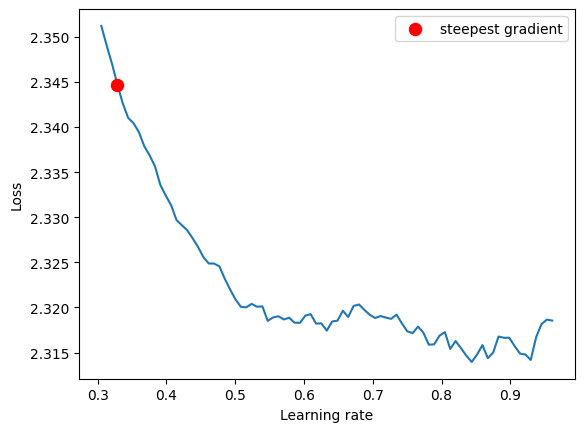

0.3287419651056015


wandb: Network error (ConnectTimeout), entering retry loop.
Bad pipe message: %s [b'untu; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/113.0\r\nAccept: */*\r\nAccept-Lang']
Bad pipe message: %s [b'ge: en-US,en;q=0.5\r\nAccept-Encoding: gzip, deflate, br\r\nSec-WebSocket-Version: 13\r\nOrigin: https://discord.com\r\nSec-', b'bSocket-Extensions: permessage-deflate\r\nSec-WebSocket-Key: SjlGeRvf8sdv2MD6nqeX7Q==\r\nC', b'nection: keep-alive, Upgrade\r\nSec-Fetch-Dest: websocket\r\nSec-Fetch-Mode: websocket\r\nSec-Fetch-Site: cross-site']
Bad pipe message: %s [b'Pragma: no-c']


In [43]:
lr_finder.range_test(train_loader, end_lr=1, num_iter=100, step_mode="linear",diverge_th=100)
ax, lr = lr_finder.plot(log_lr=False)
print(lr)
lr_finder.reset()
lr_scheduler = CyclicLR(optimizer, base_lr=lr/3, max_lr=lr,)


if arch in ['resnet1202', 'resnet110']:
    # for resnet1202 original paper uses lr=0.01 for first 400 minibatches for warm-up
    # then switch back. In this setup it will correspond for first epoch.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr*0.1

In [ ]:
for epoch in range(start_epoch, epochs):

    # train for one epoch
    print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
    top1 = train(train_loader, model, criterion, optimizer, epoch, preconditioner)
    # lr_scheduler.step()

    # evaluate on validation set
    prec1 = validate(val_loader, model, criterion)

    # remember best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)

    if epoch > 0 and epoch % save_every == 0:
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best, filename=os.path.join(save_dir, 'checkpoint.th'))

    save_checkpoint({
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
    }, is_best, filename=os.path.join(save_dir, 'model.th'))

    wandb.log({'epoch':epoch,'train_acc':top1,'val_acc':prec1,'lr':optimizer.param_groups[0]['lr']})